In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt
import os
from imageio import imwrite
import cv2 as cv
import pandas as pd
import shutil
from IPython import display
import time
from functools import cmp_to_key
from statistics import mean
%matplotlib inline

In [ ]:
# turn on acceleration
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


2022-05-10 18:14:45.279913: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 18:14:45.402567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 18:14:45.403371: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [ ]:
# all used filepaths
discriminator_path = "data/models/discrim.h5"
generator_path = "data/models/generat.h5"
output_path = "data/output/test"
input_path = '../input/abstract-art-gallery/Abstract_gallery'
path_history = f"{output_path}/history.csv"
path_gallery = f"{output_path}/gallery_generated_"
save_path = output_path + "/models"

In [ ]:
def save_history(d_loss, d_acc, g_loss):
    history = pd.DataFrame({'Discriminator loss': [d_loss],
                           'Discriminator accuracy x100': [d_acc],
                           'Generator loss': [g_loss]})
    history.to_csv(path_history, mode='a', header=not os.path.exists(save_path))

In [ ]:
def save_imgs(epoch, imgs, gallery_size, img_size):
    imgs = 0.5 * imgs + 0.5
    
    # individual images
    for i, img_array in enumerate(imgs):
        path = f"{output_path}/generated_{img_size[0]}x{img_size[1]}"
        if not os.path.exists(path):
            os.makedirs(path)
        imwrite(path + f"/{epoch}_{i}.png", img_array)
    
    # gallery of images
    nindex, height, width, intensity = imgs.shape
    nrows = nindex // gallery_size[1]
    assert nindex == nrows * gallery_size[1]
    # want result.shape = (height*nrows, width*ncols, intensity)
    gallery = (imgs.reshape(nrows, gallery_size[1], height, width, intensity)
              .swapaxes(1, 2)
              .reshape(height * nrows, width * gallery_size[1], intensity))

    path = f"{output_path}/gallery_generated_{img_size[0]}x{img_size[1]}"
    if not os.path.exists(path):
        os.makedirs(path)
    imwrite(path + f"/{epoch}.png", gallery)

In [ ]:
def sort_filenames(x1, x2):
    n1 = int(x1[:-4])
    n2 = int(x2[:-4])
    return n1 - n2

In [ ]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
SEED = 0
KERNEL_SIZE = 4
CHANNELS = 3
EPOCHS = 200
SAVE_INTERVAL = 25
NOISE_DIM = 100

## Loading dataset

In [ ]:
def load_imgs(image_path, img_size, batch_size):
    dataset = image_dataset_from_directory(image_path, label_mode=None, image_size=img_size, batch_size=batch_size)
    dataset = dataset.map(lambda x: x/255.0)
    example_batch = dataset.take(1)
    plt.figure(figsize=(10,10))
    for images in example_batch:
        for i in range(32):
            ax = plt.subplot(4, 8, i + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow((images[i].numpy()*255).astype("int32"))
    return dataset

In [ ]:
def image_generator(image_path, img_size, batch_size):
    generator = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
    dataset_generator = generator.flow_from_directory(
        image_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode=None)

    return generator

In [ ]:
train_generator = image_generator(input_path, IMG_SIZE, BATCH_SIZE)

Found 2782 images belonging to 1 classes.


Found 2782 files belonging to 1 classes.


2022-05-10 18:14:48.337054: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-10 18:14:48.337428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 18:14:48.338254: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-10 18:14:48.338886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

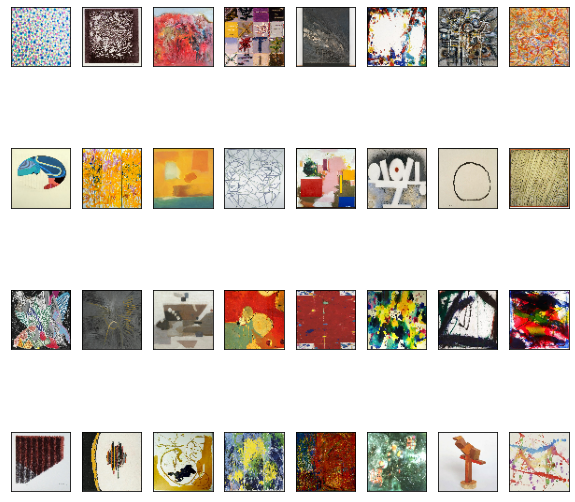

In [ ]:
dataset = load_imgs(input_path, IMG_SIZE, BATCH_SIZE)

## Build model

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)            

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 512)       20

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128, save_interval=10):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.save_interval = save_interval

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.save_interval == 0:
            random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
            generated_images = self.model.generator(random_latent_vectors)
            generated_images *= 255
            generated_images.numpy()
            directory_path = f"{output_path}/{epoch}"
            if not os.path.exists(directory_path):
                os.makedirs(directory_path)
            for i in range(self.num_img):
                img = keras.preprocessing.image.array_to_img(generated_images[i])
                img.save(f"{directory_path}/{i}.png")

In [ ]:
epochs = 100  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/100


2022-05-10 18:15:08.970816: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


87/87 [==============================] - 27s 199ms/step - d_loss: 0.6217 - g_loss: 0.9178
Epoch 2/100
87/87 [==============================] - 13s 143ms/step - d_loss: 0.4010 - g_loss: 2.5934
Epoch 3/100
87/87 [==============================] - 13s 138ms/step - d_loss: 0.6125 - g_loss: 0.9312
Epoch 4/100
87/87 [==============================] - 13s 139ms/step - d_loss: 0.5378 - g_loss: 1.7056
Epoch 5/100
87/87 [==============================] - 13s 141ms/step - d_loss: 0.7289 - g_loss: 0.8679
Epoch 6/100
87/87 [==============================] - 13s 137ms/step - d_loss: 0.6193 - g_loss: 1.3071
Epoch 7/100
87/87 [==============================] - 13s 139ms/step - d_loss: 0.6379 - g_loss: 0.9987
Epoch 8/100
87/87 [==============================] - 13s 140ms/step - d_loss: 0.8560 - g_loss: 1.3685
Epoch 9/100
87/87 [==============================] - 13s 138ms/step - d_loss: 0.3813 - g_loss: 3.6379
Epoch 10/100
87/87 [==============================] - 13s 139ms/step - d_loss: 0.6506 - g_loss

## Generate new images

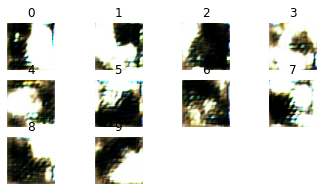

In [ ]:
noise = tf.random.normal(shape=(10, 128))
generated_images = gan.generator(noise)
generated_images *= 255
generated_images.numpy()
for i in range(10):
    img = keras.preprocessing.image.array_to_img(generated_images[i])
    ax = plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.axis("off")
    ax.set_title(i)

In [ ]:
gan.discriminator.save(f"{output_path}/models/discriminator.h5")
gan.generator.save(f"{output_path}/models/generator.h5")

In [ ]:
! ls data/output/test/models

discriminator.h5  generator.h5


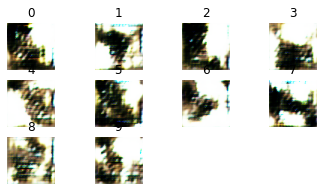

In [ ]:
test = keras.models.load_model("data/output/test/models/generator.h5")
noise = tf.random.normal(shape=(10, 128))
test_images = test(noise)
test_images *= 255
test_images.numpy()
for i in range(10):
    img = keras.preprocessing.image.array_to_img(test_images[i])
    ax = plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.axis("off")
    ax.set_title(i)

## Clean up

In [ ]:
shutil.rmtree("data/output/test")

In [ ]:
os.path.exists("data/output/test")